In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'pytorch'

In [ ]:
import deepxde as dde 
import numpy as np 
import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/userhome/jeon_mg/miniforge3/envs/pinn_torch/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [ ]:
layer_size = [3] + [256] * 8 + [3]
activation = 'sin'
initializer = 'Glorot normal'

net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(None, net)

In [ ]:
model.compile('adam', lr=5e-4)

Compiling model...
'compile' took 0.274348 s



In [ ]:
model.restore('model3/nf2-99000.pt')

In [ ]:
spatial_norm = 256
b_norm = 2500

In [ ]:
coords = np.stack(np.mgrid[:513, :257, :257], -1).astype(np.float32) / spatial_norm

In [ ]:
from tqdm import tqdm

In [ ]:
batch_size=1000

coords_shape = coords.shape
coords = coords.reshape((-1, 3))

cube = []
it = range(int(np.ceil(coords.shape[0] / batch_size)))
it = tqdm(it)
for k in it:
    coord = coords[k * batch_size: (k + 1) * batch_size]
    cube += [model.predict(coord)]

100%|██████████| 33884/33884 [00:31<00:00, 1080.42it/s]


In [ ]:
cube = np.concatenate(cube)
cube = cube.reshape(*coords_shape)
b = cube * b_norm

In [ ]:
import netCDF4

In [ ]:
def load_nc_only_b(nc_file):
    nc=netCDF4.Dataset(nc_file, 'r')
    
    nc_bx=nc.variables['Bx']
    bx=nc_bx[:].transpose(2,1,0)
    nc_by=nc.variables['By']
    by=nc_by[:].transpose(2,1,0)
    nc_bz=nc.variables['Bz']
    bz=nc_bz[:].transpose(2,1,0)

    b = np.stack([bx, by, bz], -1)
    b = np.array(b)
    return b

In [ ]:
B = load_nc_only_b("/mnt/obsdata/isee_nlfff_v1.2/12673/12673_20170906_083600.nc")

In [ ]:
import numpy as np

def vector_norm(vector):
    return np.linalg.norm(vector, axis=-1)

def dot_product(a, b):
    return (a*b).sum(-1)


def metric(b, B):
    # b : model solution
    # B : reference magnetic field
    eps = 1e-7

    result = {}

    result['c_vec'] = np.sum(dot_product(B, b)) / np.sqrt(np.sum(vector_norm(B)**2) * np.sum(vector_norm(b)**2))
    
    M = np.prod(B.shape[:-1])
    nu = dot_product(B, b)
    de = vector_norm(B) * vector_norm(b)
    result['c_cs'] = (1 / M) * np.sum(np.divide(nu, de, where=de!=0.))

    E_n = np.sum(vector_norm(b - B)) / np.sum(vector_norm(B))
    result["E_n'"] = 1 - E_n
    
    nu = vector_norm(b - B)
    de = vector_norm(B)
    E_m = (1 / M) * np.sum(np.divide(nu, de, where=de!=0.))
    result["E_m'"] = 1 - E_m

    result['eps'] = np.sum(vector_norm(b)**2) / np.sum(vector_norm(B)**2)

    return result

import matplotlib.pyplot as plt 

def plot_overview(b, B, z=0, b_norm=2500):
    fig, axs = plt.subplots(2, 3, figsize=(12, 4))

    ax = axs[0]
    ax[0].imshow(b[..., z, 0].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[0].set_title('bx')
    ax[1].imshow(b[..., z, 1].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[1].set_title('by')
    ax[2].imshow(b[..., z, 2].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[2].set_title('bz')

    ax = axs[1]
    ax[0].imshow(B[..., z, 0].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[0].set_title('Bx')
    ax[1].imshow(B[..., z, 1].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[1].set_title('By')
    ax[2].imshow(B[..., z, 2].transpose(), vmin=-b_norm, vmax=b_norm, cmap='gray', origin='lower')
    ax[2].set_title('Bz')

    plt.tight_layout()
    plt.show()

def plot_s(mag, title, n_samples):
    fig, axs = plt.subplots(3, n_samples, figsize=(n_samples * 4, 12))
    heights = np.linspace(0, 1, n_samples) ** 2 * (mag.shape[2] - 1)  # more samples from lower heights
    heights = heights.astype(np.int32)
    for i in range(3):
        for j, h in enumerate(heights):
            v_min_max = np.max(np.abs(mag[:, :, h, i]))
            axs[i, j].imshow(mag[:, :, h, i].transpose(), cmap='gray', vmin=-v_min_max, vmax=v_min_max,
                            origin='lower')
            axs[i, j].set_axis_off()
    for j, h in enumerate(heights):
        axs[0, j].set_title('%.01f' % h)
    fig.tight_layout()
    fig.suptitle(title, fontsize=25)
    plt.show()

def plot_sample(b, B, n_samples=10):
    plot_s(b, 'b', n_samples)
    plot_s(B, 'B', n_samples)

In [ ]:
result = metric(b, B)

In [ ]:
print(result)

{'c_vec': 0.7408147321088031, 'c_cs': 0.11928336345208843, "E_n'": -0.8576857776080422, "E_m'": -7.4577714661896, 'eps': 1.515490027021962}


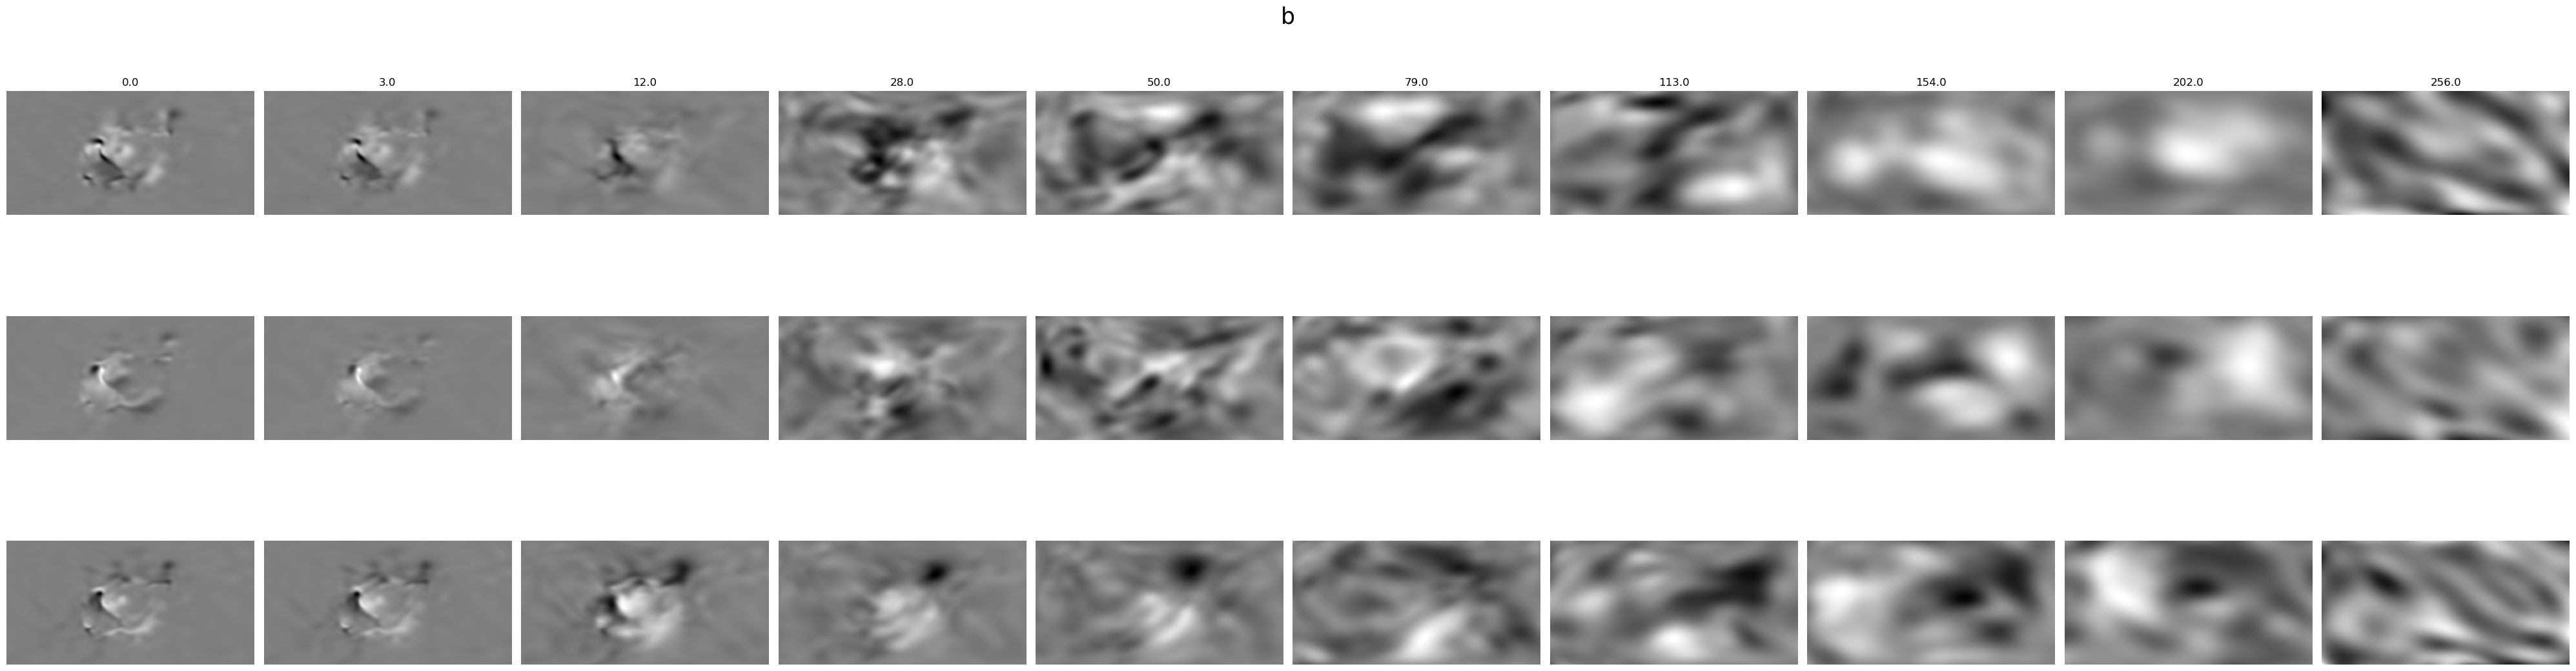

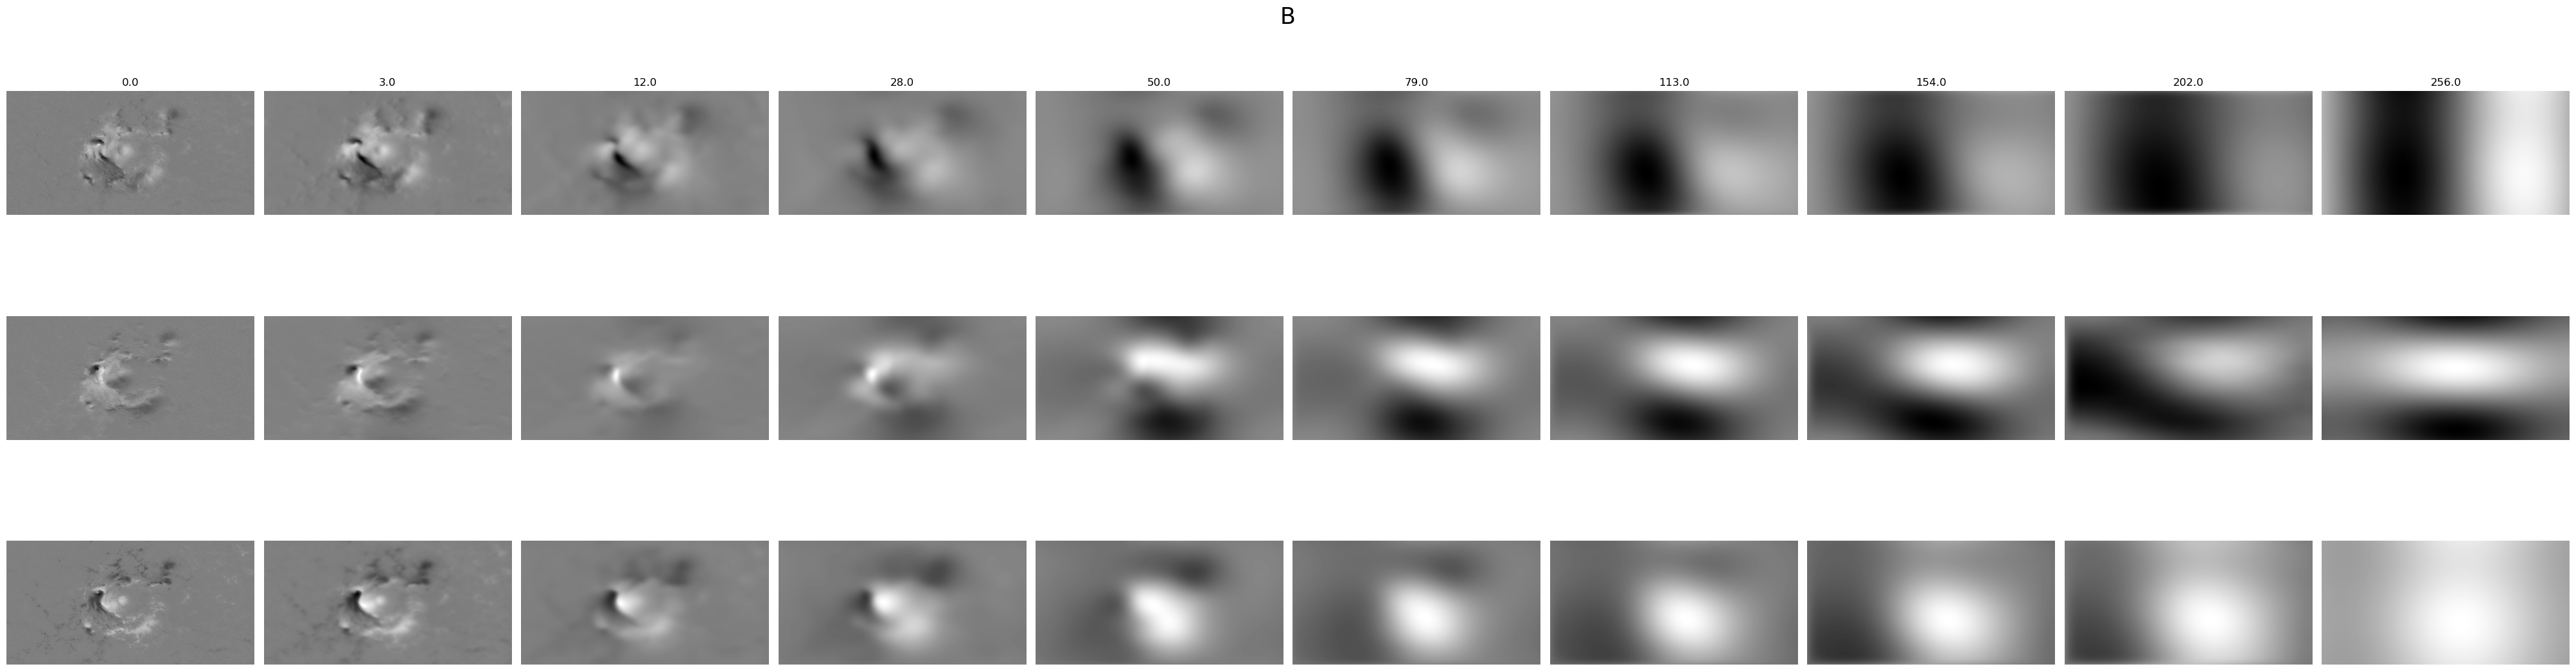

In [ ]:
plot_sample(b, B, n_samples=10)

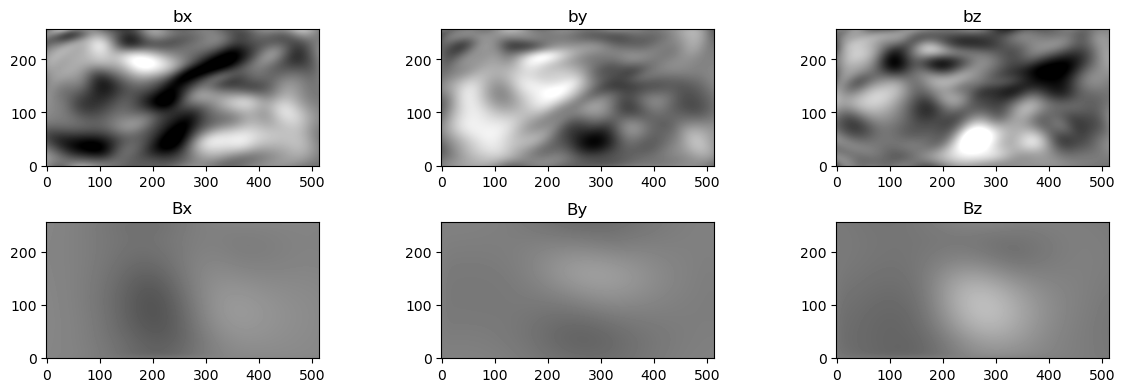

: 

In [ ]:
plot_overview(b, B, z=100, b_norm=100)